## Anonymously Download CFS data from AWS

### Explicit Dependencies:
- boto3
- botocore
- datetime
- xarray
- matplotlib
- cfgrib

### Implicit Dependencies:
These also have to be installed because either `xarray` or `cfgrib` depends on them:
- netcdf4
- scipy
- dask


In [1]:
import boto3
import botocore
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib

cfs_bucket = 'noaa-cfs-pds'

# Want to get 5 days worth of forecast data = 5 days x 4 forecast cycles/day
cycles2get = 4*5 

### 1. Set up `boto3` client and explore bucket

In [2]:
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [3]:
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=cfs_bucket, Delimiter='/')

count = 0

for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))
    count += 1 
    if(count>49):
        break # skip the for loop after reporting 50 values

cfs.20181031/
cfs.20181101/
cfs.20181102/
cfs.20181103/
cfs.20181104/
cfs.20181105/
cfs.20181106/
cfs.20181107/
cfs.20181108/
cfs.20181109/
cfs.20181110/
cfs.20181111/
cfs.20181112/
cfs.20181113/
cfs.20181114/
cfs.20181115/
cfs.20181116/
cfs.20181117/
cfs.20181118/
cfs.20181119/
cfs.20181120/
cfs.20181121/
cfs.20181122/
cfs.20181123/
cfs.20181124/
cfs.20181125/
cfs.20181126/
cfs.20181127/
cfs.20181128/
cfs.20181129/
cfs.20181130/
cfs.20181201/
cfs.20181202/
cfs.20181203/
cfs.20181204/
cfs.20181205/
cfs.20181206/
cfs.20181207/
cfs.20181208/
cfs.20181209/
cfs.20181210/
cfs.20181211/
cfs.20181212/
cfs.20181213/
cfs.20181214/
cfs.20181215/
cfs.20181216/
cfs.20181217/
cfs.20181218/
cfs.20181219/


### Make sure we can construct the correct path to files on the AWS bucket

In [4]:
keys = []
date = datetime.datetime(2022,11,28,hour=0)
prefix = date.strftime('cfs.%Y%m%d/00/6hrly_grib_01/')

print(prefix)

cfs.20221128/00/6hrly_grib_01/


### List the files in our path of interest in the AWS bucket

Note, this will try to list all of the files in that folder, which is more than can be queried using `botocore` - a low-level engine that allows anonymous access.

In [5]:
response = client.list_objects_v2(Bucket=cfs_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B %d, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B %d, %Y')))
        
        count = 0
        for k in keys:
            print(k)
            
            count += 1 
            if(count>49):
                break # skip the for loop after reporting 50 values
else:
    print("There was an error with your request.")

There are 1000 objects available for November 28, 2022
--
cfs.20221128/00/6hrly_grib_01/flxf2022112800.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112800.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112806.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112806.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112812.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112812.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112818.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112818.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112900.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112900.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112906.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112906.01.2022112800.grb2.idx
cfs.20221128/00/6hrly_grib_01/flxf2022112912.01.2022112800.grb2
cfs.20221128/00/6hrly_grib_01/flxf2022112912.01.2022112800.grb2.idx
cfs.20221128/00/6h

### Construct the file names of the files we want to download.

CFS file names look like `flxf2023040118.01.2022112800.grb2` where `flxf` means fluxes, the date string to the left of the first `.` is in `YYYYMMDDHH` format and is the __valid date and time__ for that forecast file, the two digit number (`01` in this case) is the ensemble member (CFS runs 4 ensemble members), the second date string to the right of the second `.` is also in `YYYYMMDDHH` format and is the __forecast date and time__ – i.e., the date and time that the forecast was initiated. The files have the `.grb2` indicating they are GrIB v2 files.   

In [6]:
cfs_filebase = 'flxf' 

sdate = date
ensnum = '01' # CFS Ensemble number
fdate = sdate

flx_files = []

for i in range(cycles2get):
    
    sdatestr = sdate.strftime('%Y%m%d%H')
    fdatestr = fdate.strftime('%Y%m%d%H')
    
    flx_file = cfs_filebase+fdatestr + '.' + ensnum + '.' + sdatestr+'.grb2'
    
    flx_files.append(flx_file)
    
    # Update the valid datetime by adding six hours from the valid time just used
    fdate = fdate + datetime.timedelta(hours=6)
    

### Download the files

Note: There's no reason this couldn't be done in the for loop above (although the loop above is fast and then you have a record of the file names you __*tried*__ to download).  

In [7]:
for flx_file in flx_files:
    print('Downloading '+flx_file)
    client.download_file(cfs_bucket,prefix+flx_file,flx_file)

### Use `xarray.open_mfdataset` along with the `cfgrib` engine to open and concatenate the data

In [8]:
ds_cfs = xr.open_mfdataset('flxf*.grb2',engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'},concat_dim='valid_time',combine='nested')
ds_cfs

<xarray.Dataset>
Dimensions:     (valid_time: 20, latitude: 190, longitude: 384)
Coordinates:
    time        datetime64[ns] 2022-11-28
    step        (valid_time) timedelta64[ns] 0 days 00:00:00 ... 4 days 18:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 89.28 88.34 87.4 ... -87.4 -88.34 -89.28
  * longitude   (longitude) float64 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * valid_time  (valid_time) datetime64[ns] 2022-11-28 ... 2022-12-02T18:00:00
Data variables: (12/53)
    uflx        (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    vflx        (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    shtfl       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    lhtfl       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    t           (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    sdwe        (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    ...          ...
    snohf       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    vbdsf       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    vddsf       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    nbdsf       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    nddsf       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
    srweq       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 190, 384), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-30T11:56 GRIB to CDM+CF via cfgrib-0.9.1...

### Get just the precipitation data and save as an `xarray` data array

And then save it to a NetCDF file

In [9]:
da_cfs_prate = ds_cfs['prate']
da_cfs_prate

<xarray.DataArray 'prate' (valid_time: 20, latitude: 190, longitude: 384)>
dask.array<concatenate, shape=(20, 190, 384), dtype=float32, chunksize=(1, 190, 384), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] 2022-11-28
    step        (valid_time) timedelta64[ns] 0 days 00:00:00 ... 4 days 18:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 89.28 88.34 87.4 ... -87.4 -88.34 -89.28
  * longitude   (longitude) float64 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * valid_time  (valid_time) datetime64[ns] 2022-11-28 ... 2022-12-02T18:00:00
Attributes: (12/25)
    GRIB_paramId:                             3059
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      72960
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Precipitation rate
    GRIB_shortName:                           prate
    GRIB_units:                               kg m**-2 s**-1
    long_name:                                Precipitation rate
    units:                                    kg m**-2 s**-1
    standard_name:                            unknown

In [10]:
da_cfs_prate.to_netcdf('cfs_prate_'+sdate.strftime('%Y%m%d')+'.nc')

### Plot the cumulative precipitation over the period just to make sure it makes sense

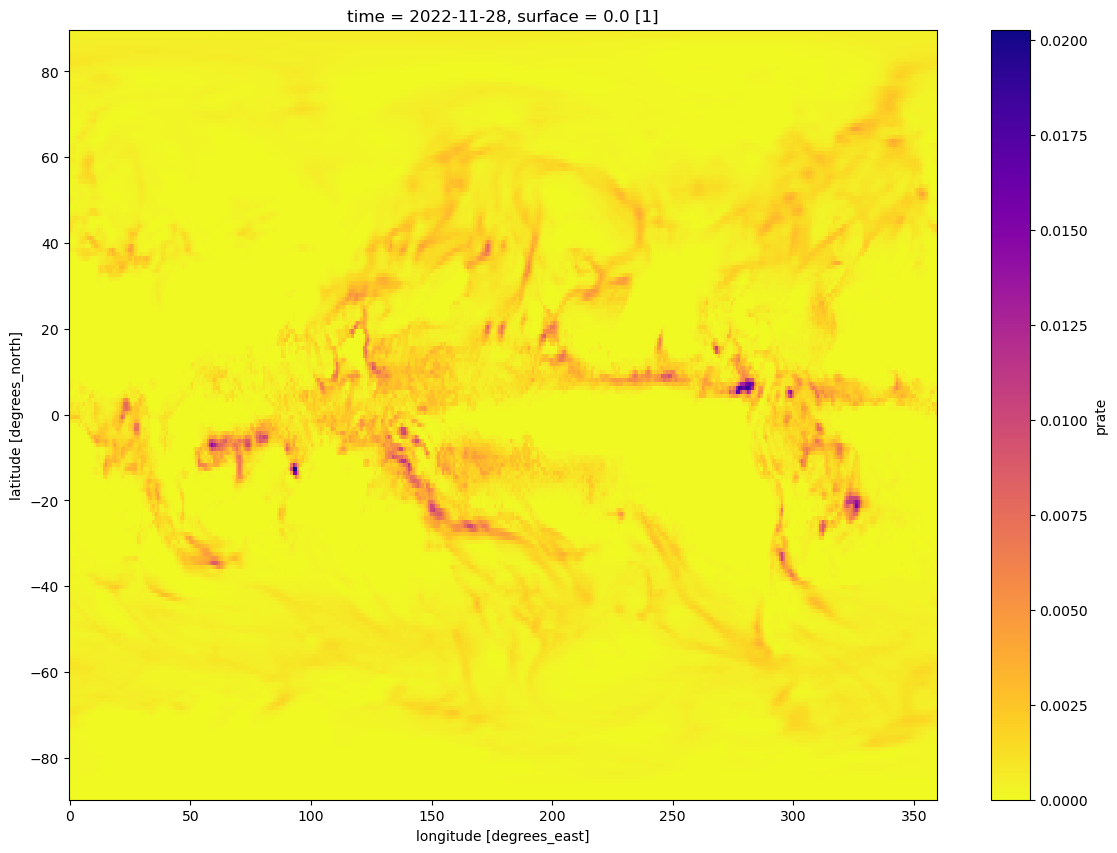

In [11]:
da_cfs_prate.sum(dim='valid_time').plot(cmap='plasma_r',figsize=(14,10))

### Verify the NetCDF file has the same info

In [12]:
ds_cfs_prate_from_nc = xr.open_dataset('cfs_prate_'+sdate.strftime('%Y%m%d')+'.nc')
ds_cfs_prate_from_nc

<xarray.Dataset>
Dimensions:     (valid_time: 20, latitude: 190, longitude: 384)
Coordinates:
    time        datetime64[ns] ...
    step        (valid_time) timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.28 88.34 87.4 ... -87.4 -88.34 -89.28
  * longitude   (longitude) float64 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * valid_time  (valid_time) datetime64[ns] 2022-11-28 ... 2022-12-02T18:00:00
Data variables:
    prate       (valid_time, latitude, longitude) float32 ...

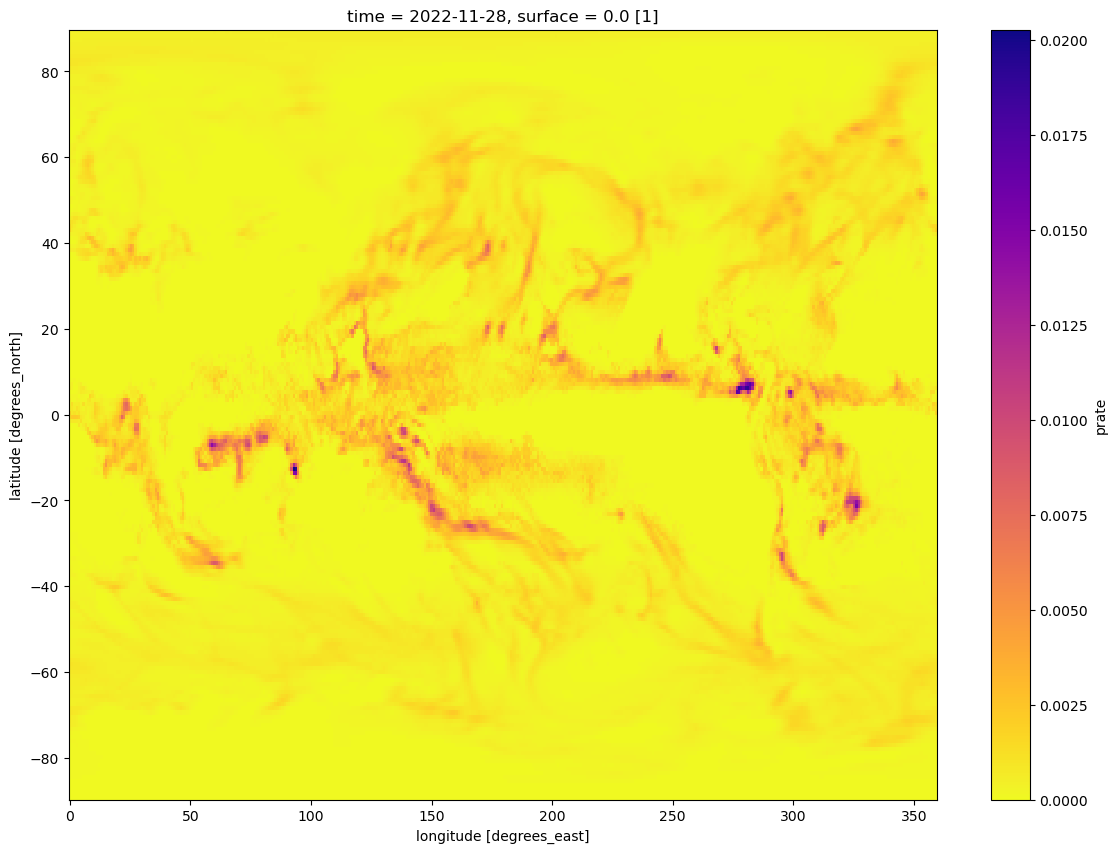

In [13]:
ds_cfs_prate_from_nc.prate.sum(dim='valid_time').plot(cmap='plasma_r',figsize=(14,10))

## ^ - Looks Right! 

Note - the units of `prate` are kg/(m^2 s). To get mm/day multiply by 86400.  

### Make sure its a time series by grabbing the pixel nearest Boise and plotting

Text(0, 0.5, 'Precipitation [kg/(m${}^2$s)]')

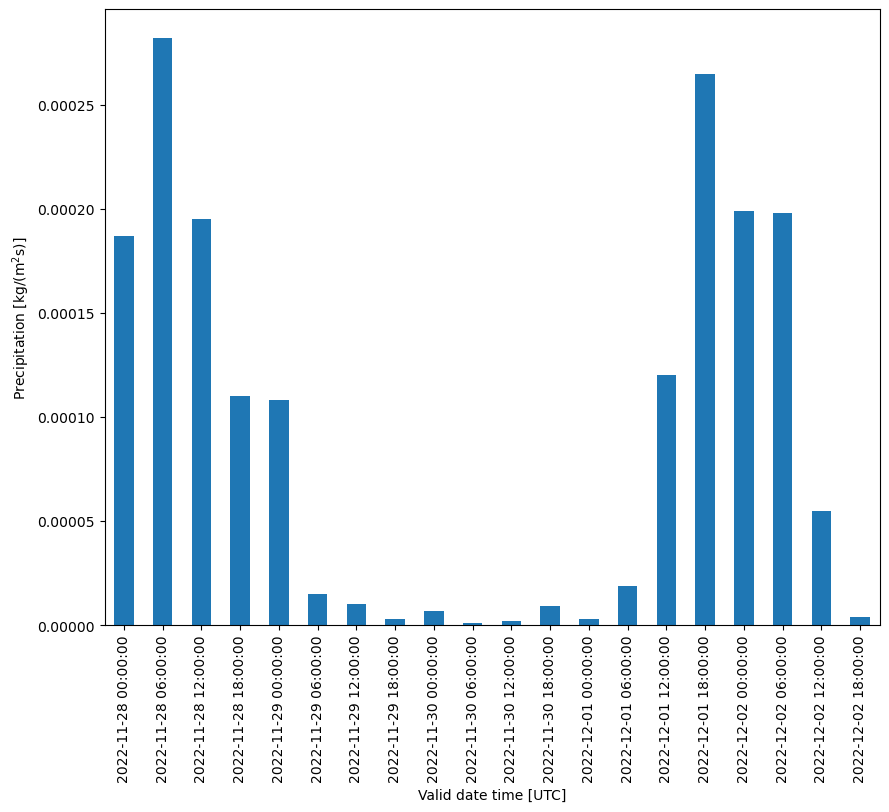

In [14]:
da_prate_boi = ds_cfs_prate_from_nc.sel(longitude=(-116.2023+360), latitude=43.6150, method='nearest')

prate_boi = da_prate_boi.prate.to_series()

prate_boi.plot.bar(figsize=(10,8))

plt.xlabel('Valid date time [UTC]')
plt.ylabel('Precipitation [kg/(m${}^2$s)]')